In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import impedance

from impedance.visualization import plot_nyquist
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
from impedance.validation import linKK
from sklearn.linear_model import LinearRegression

In [2]:
#Converts text file exported from Biologic into form ready for preprocessing

data = 'E47-LFP_475um_E58-Graphite_150um_EMC70_EC30_2VC_PEIS_steps_02_PEIS_C01 - Copy.txt'

df = pd.read_csv(data, sep="\t", encoding= 'unicode_escape')
df1 = df.iloc[:, 0:3] 
df1 = df1.rename(columns={'freq/Hz': 'freq_Hz', 'Re(Z)/Ohm':'Re_Z_Ohm', '-Im(Z)/Ohm':'Im_Z_Ohm'}) 

df1.Im_Z_Ohm = df1.Im_Z_Ohm*-1

s = df1['freq_Hz'].shift() <= df1['freq_Hz']

#s = df['I_mA'].shift().eq(0) & df['control_mA'].lt(0)
df1['segment'] = s.cumsum() + 1

seg = 1

df2 = df1[df1['segment'] == seg] 

df2.to_csv("data.csv", index = False)



In [3]:
#Formats dataframe for impedance fitting and analysis

freq, Z = preprocessing.readCSV('./data.csv')

#This Biologic prepreprocessing code does not work.
#freq, Z = preprocessing.readBioLogic('./319_02_PEIS_CF1.mpr')

#This part seems to get rid of NaN values
freq, Z = preprocessing.cropFrequencies(freq, Z, freqmin=0, freqmax=None)




In [4]:
#Validate data with Kramers-Kronig (KK) method
#doi: 10.1016/j.electacta.2014.01.034
#M is the number of RC elements, mu is the 'u' given by eq. 21 in linked paper

mask = freq < 100000
freq_KK = freq [mask]
Z_KK = Z[mask]

M, mu, Z_linKK, res_real, res_imag = linKK(freq_KK, Z_KK, c=.5, max_M=100, fit_type='complex', add_cap=True)

#print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))

10 0.9956646321012623 0.01890416397674519
20 0.9403003766302721 0.00786087721848941
30 0.5622120921317875 0.007676218072892425


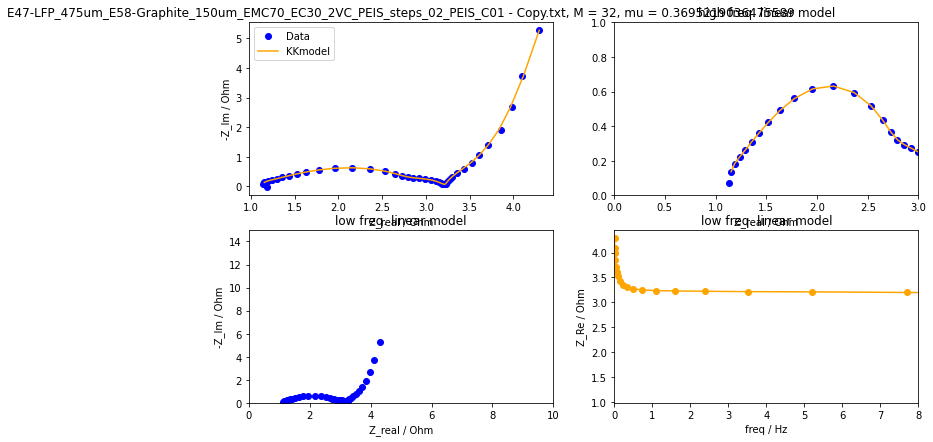

In [5]:
#Quick Nyquist visualisation to assess basic parameters and do KK fit

fig, ax = plt.subplots(2, 2, figsize=(12,7))
lns1 = ax[0, 0].plot(Z.real, -Z.imag, color='blue', marker ='o', linestyle ='None', label = "Data") 
lns2 = ax[0, 0].plot(Z_linKK.real, -Z_linKK.imag, color='orange', linestyle ='-', label = "KKmodel") 
ax[0, 0].set_ylabel('-Z_Im / Ohm')
ax[0, 0].set_xlabel('Z_real / Ohm')

#Zoom into early semi-circles

#xlim = 10
#xlim2 = R_lowf - 50
#ylim = 25

#ax[0, 0].set_xlim(0, xlim)
#ax[0, 0].set_ylim(0, ylim)

ax[0, 0].set_title(str(data)+', M = '+str(M)+', mu = '+str(mu))
ax[0, 1].set_title('high freq. linear model')
ax[1, 0].set_title('low freq. linear model')
ax[1, 1].set_title('low freq. linear model')

lns3 = ax[0,1].plot(Z.real, -Z.imag, color='blue', marker ='o', linestyle ='None', label = "Data")
lns4 = ax[0,1].plot(Z_linKK.real, -Z_linKK.imag, color='orange', linestyle ='-', label = "KKmodel")
#lns5 = ax[0,1].plot(Z_Re_highf_fit, -Z_Im_highf_fit, color='black', linestyle ='--', label = "linear")
ax[0,1].set_xlabel('Z_real / Ohm')

ax[0,1].set_xlim(0, 3)
ax[0,1].set_ylim(0, 1)

lns6 = ax[1,0].plot(Z.real, -Z.imag, color='blue', linestyle ='None', marker ='o', label = "Z-real") 
#lns7 = ax[1,0].plot(Z_Re_lowf_fit, -Z_Im_lowf_fit, color='black', linestyle ='--', label = "linear")
ax[1,0].set_ylabel('-Z_Im / Ohm')
ax[1,0].set_xlabel('Z_real / Ohm')
#ax[1, 0].set_xlim(xlim2, max(Z.real))
ax[1,0].set_xlim(0, 10)
ax[1,0].set_ylim(0, 15)

lns8 = ax[1,1].plot(freq, Z.real, color='orange', marker ='o', label = "Z-real") 
ax[1,1].set_xlim(0, 8)
ax[1,1].set_ylabel('Z_Re / Ohm')
ax[1,1].set_xlabel('freq / Hz')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax[0, 0].legend(lns, labs, loc='upper left')

plt.show()

In [6]:
#Define circuit element and build starting guess model
#Transmission line model TLMQ: Rion, Qs, gamma = p[0], p[1], p[2]



#Fit 1 based on reduced frequency range
circuit1 = 'R0-p(R1,CPE0)-p(R2,CPE1)-p(R3,CPE2)-W'
initial_guess1 = [0.0002]
constant1 = {'R0':1.1, 'CPE0_0':0.00003, 'CPE0_1':0.7 , 'R1':0.3, 'R2':1.4, 'R3':0.3, 'CPE2_1': 0.9 ,'CPE1_0':0.000292, 'CPE1_1':0.85, 'W': 1}
circuit1 = CustomCircuit(circuit1, initial_guess=initial_guess1, constants = constant1)



#Fit 2 based on reduced frequency range
circuit2 = 'R0-p(R1,CPE0)-p(R2-C1,CPE1)-W'
initial_guess2 = [2.07, 0.001, 1.24, 0.00137, 0.0138]
constant2 = {'R0': 1.05, 'CPE0_0':1.33e-03, 'CPE0_1':6.80e-01, 'CPE1_1':6.83e-01} 
circuit2 = CustomCircuit(circuit2, initial_guess=initial_guess2,
                      constants = constant2)


#Sim 1 based on reduced frequency range
circuit3 = 'R0-p(R1,CPE0)-W'
#initial_guess3 = [0.8]
constant3 = {'R0':1.4, 'R1': 1.4, 'CPE0_0': 0.000292, 'CPE0_1': 0.85, 'W': 1}
circuit3 = CustomCircuit(circuit3, #initial_guess=initial_guess3,
                        constants = constant3 )

#Sim 2 based on reduced frequency range
circuit4 = 'R0-p(R1,CPE0)-p(R2,CPE1)-W'
#initial_guess4 = [0.8]
constant4 = {'R0':30.7,'R1':22.1,'CPE0_0': 0.000038, 'CPE0_1': 0.94,  'R2': 82, 'CPE1_0': 0.000614, 'CPE1_1': 0.693, 'W':6.48}
circuit4 = CustomCircuit(circuit4, #initial_guess=initial_guess4,
                        constants = constant4 )



In [7]:
#Crop data to only retain part of data to fit

freqmin1 = 0.01
freq1, Z1 = preprocessing.cropFrequencies(freq, Z, freqmin=freqmin1, freqmax=200000)

freqmin2 = 0.01
freq2, Z2 = preprocessing.cropFrequencies(freq, Z, freqmin=freqmin2, freqmax=200000)

In [8]:
#Fit EIS model for full data

circuit1.fit(freq1, Z1)
Z_fit1 = circuit1.predict(freq1)

circuit2.fit(freq2, Z2)
Z_fit2 = circuit2.predict(freq2)

Z_sim1 = circuit3.predict(freq)
Z_sim2 = circuit4.predict(freq)



C:\Users\SunyhikAhn\anaconda3\lib\site-packages\impedance\models\circuits\circuits.py:166: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


In [9]:
#Tease out and calculate values for phase angle and Z_mod (to avoid using built in visualise package)

Z_mod_exp = np.sqrt((Z.real*Z.real) + (Z.imag*Z.imag))
phase_exp = np.arctan(Z.imag/Z.real)

Z_mod_fit1 = np.sqrt((Z_fit1.real*Z_fit1.real) + (Z_fit1.imag*Z_fit1.imag))
phase_fit1 = np.arctan(Z_fit1.imag/Z_fit1.real)

Z_mod_fit2 = np.sqrt((Z_fit2.real*Z_fit2.real) + (Z_fit2.imag*Z_fit2.imag))
phase_fit2 = np.arctan(Z_fit2.imag/Z_fit2.real)

Z_mod_sim1 = np.sqrt((Z_sim1.real*Z_sim1.real) + (Z_sim1.imag*Z_sim1.imag))
phase_sim1 = np.arctan(Z_sim1.imag/Z_sim1.real)

Z_mod_sim2 = np.sqrt((Z_sim2.real*Z_sim2.real) + (Z_sim2.imag*Z_sim2.imag))
phase_sim2 = np.arctan(Z_sim2.imag/Z_sim2.real)

In [10]:
#Save values into dataframe and export

df_res = pd.DataFrame()

df_res['freq_exp'] = freq
df_res['Z_Re_exp'] = Z.real
df_res['nZ_Im_exp'] = Z.imag
df_res['Z_mod_exp'] = Z_mod_exp
df_res['phase_exp'] = phase_exp

df_res1 = pd.DataFrame()

df_res1['Z_Re_fit'] = Z_fit1.real
df_res1['nZ_Im_fit'] = -Z_fit1.imag
df_res1['Z_mod_fit'] = Z_mod_fit1
df_res1['phase_fit'] = phase_fit1



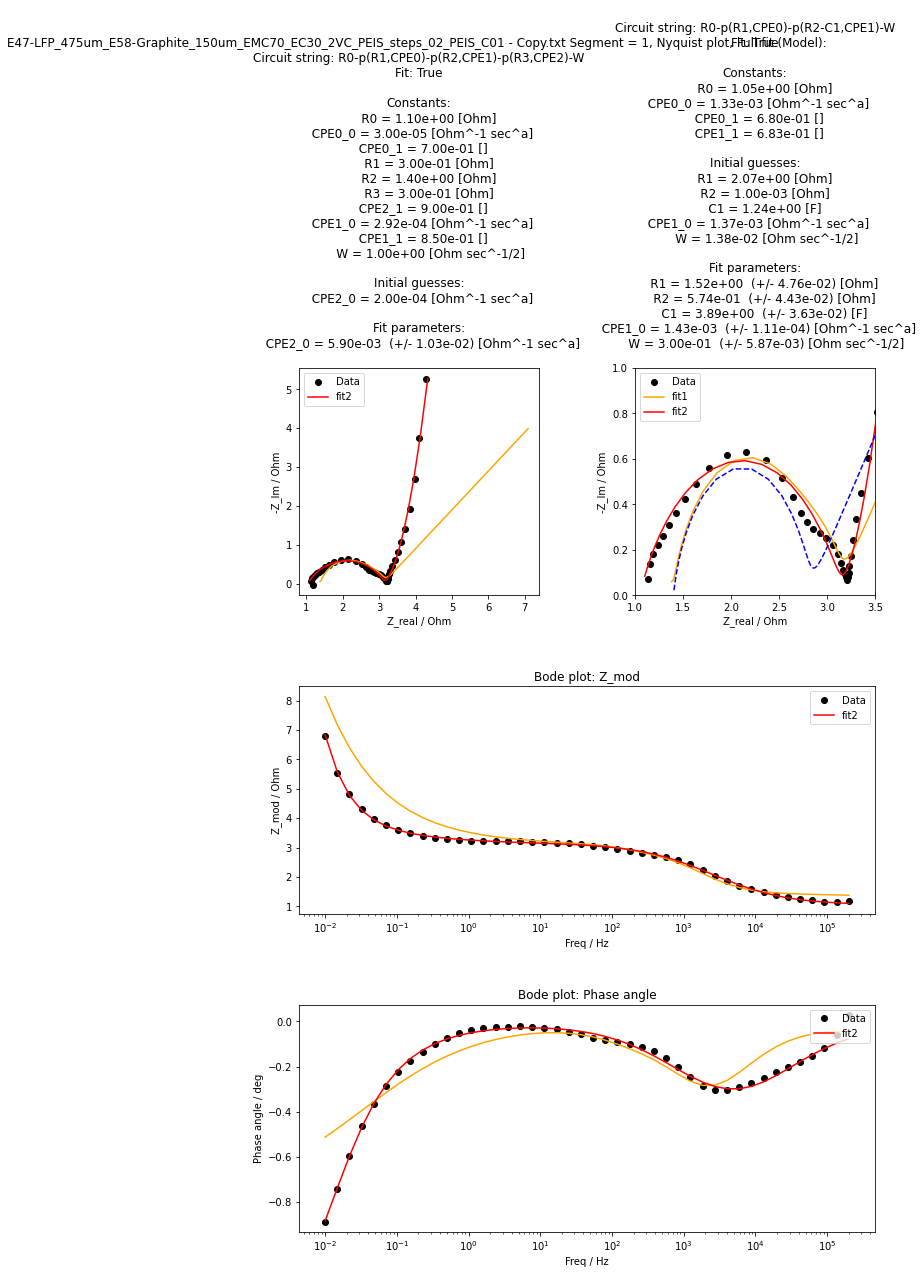

In [11]:
#Plot data and model

fig, ax = plt.subplot_mosaic([['A)','B)'], ['C)', 'C)'], ['D)', 'D)']], figsize=(8,15))

#lns1 = ax.plot(df.Re_Z_Ohm, -df.Im_Z_Ohm, color='blue', marker ='o') 
lns1 = ax['A)'].plot(Z.real, -Z.imag, color='black', marker ='o', linestyle ='None', label = "Data") 
lns2 = ax['A)'].plot(Z_fit1.real, -Z_fit1.imag, color='orange', linestyle ='-', label = "fit1") 
lns2a = ax['A)'].plot(Z_fit2.real, -Z_fit2.imag, color='red', linestyle ='-', label = "fit2") 
#lns3a = ax['A)'].plot(Z_fit1.real, Z_fit1.real, color='black', linewidth=1, linestyle ='--')
#lns3 = ax['A)'].plot(Z_sim1.real, -Z_sim1.imag, color='orange', linestyle ='--', label = 'sim1') 
#lns14a = ax['A)'].plot(Z_sim2.real, -Z_sim2.imag, color='green', linestyle ='--', label = 'sim2') 


lns10 = ax['B)'].plot(Z1.real, -Z1.imag, color='black', marker ='o', linestyle ='None', label = "Data") 
lns13 = ax['B)'].plot(Z_fit1.real, -Z_fit1.imag, color='orange', linestyle ='-', label = "fit1" ) 
lns13a = ax['B)'].plot(Z_fit2.real, -Z_fit2.imag, color='red', linestyle ='-', label = "fit2" )
lns12 = ax['B)'].plot(Z_sim1.real, -Z_sim1.imag, color='blue', linestyle ='--', label = 'sim1') 
#lns14 = ax['B)'].plot(Z_sim2.real, -Z_sim2.imag, color='green', linestyle ='--', label = 'sim2') 

lns4 = ax['C)'].plot(freq, Z_mod_exp, color='black', marker ='o', linestyle ='None', label = "Data") 
lns5 = ax['C)'].plot(freq1, Z_mod_fit1, color='orange', linestyle ='-', label = "fit1") 
lns5a = ax['C)'].plot(freq2, Z_mod_fit2, color='red', linestyle ='-', label = "fit2") 
#lns6 = ax['C)'].plot(freq, Z_mod_sim1, color='red', linestyle ='-', label = "sim1") 
#lns6a = ax['C)'].plot(freq, Z_mod_sim2, color='green', linestyle ='-', label = "sim2") 

lns7 = ax['D)'].plot(freq, phase_exp, color='black', marker ='o', linestyle ='None', label = "Data") 
lns8 = ax['D)'].plot(freq1, phase_fit1, color='orange', linestyle ='-', label = "fit1")
lns8a = ax['D)'].plot(freq2, phase_fit2, color='red', linestyle ='-', label = "fit2")
#lns9 = ax['D)'].plot(freq, phase_sim1, color='red', linestyle ='-', label = "sim1")
#lns6 = ax['D)'].plot(freq, phase_sim2, color='green', linestyle ='-', label = "sim2") 

ax['A)'].set_title(str(data)+' Segment = '+str(seg)+', Nyquist plot, Full fit (Model): '+str(circuit1))
ax['A)'].set_ylabel('-Z_Im / Ohm')
ax['A)'].set_xlabel('Z_real / Ohm')


ax['B)'].set_title(str(circuit2))
ax['B)'].set_ylabel('-Z_Im / Ohm')
ax['B)'].set_xlabel('Z_real / Ohm')
ax['B)'].set_xlim(1, 3.5)
ax['B)'].set_ylim(0, 1)

ax['C)'].set_title('Bode plot: Z_mod')
ax['C)'].set_xlabel('Freq / Hz')
ax['C)'].set_ylabel('Z_mod / Ohm')
ax['C)'].set_xscale('log')

ax['D)'].set_title('Bode plot: Phase angle')
ax['D)'].set_xlabel('Freq / Hz')
ax['D)'].set_ylabel('Phase angle / deg')
ax['D)'].set_xscale('log')


lns = lns1 + lns2a #+ lns2 +  lns3 + lns3a + lns14a
lnsa = lns10 + lns13 + lns13a 

labs = [l.get_label() for l in lns]
labsa = [l.get_label() for l in lnsa]
ax['A)'].legend(lns, labs, loc='upper left')
ax['B)'].legend(lnsa, labsa, loc='upper left')
ax['C)'].legend(lns, labs, loc='upper right')
ax['D)'].legend(lns, labs, loc='upper right')



# set the spacing between subplots
plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

In [12]:
print(str(data))
print('Segment = '+str(seg))
print(circuit1)

E47-LFP_475um_E58-Graphite_150um_EMC70_EC30_2VC_PEIS_steps_02_PEIS_C01 - Copy.txt
Segment = 1

Circuit string: R0-p(R1,CPE0)-p(R2,CPE1)-p(R3,CPE2)-W
Fit: True

Constants:
     R0 = 1.10e+00 [Ohm]
  CPE0_0 = 3.00e-05 [Ohm^-1 sec^a]
  CPE0_1 = 7.00e-01 []
     R1 = 3.00e-01 [Ohm]
     R2 = 1.40e+00 [Ohm]
     R3 = 3.00e-01 [Ohm]
  CPE2_1 = 9.00e-01 []
  CPE1_0 = 2.92e-04 [Ohm^-1 sec^a]
  CPE1_1 = 8.50e-01 []
      W = 1.00e+00 [Ohm sec^-1/2]

Initial guesses:
  CPE2_0 = 2.00e-04 [Ohm^-1 sec^a]

Fit parameters:
  CPE2_0 = 5.90e-03  (+/- 1.03e-02) [Ohm^-1 sec^a]



In [13]:
circuit2.get_param_names()

(['R1', 'R2', 'C1', 'CPE1_0', 'W'],
 ['Ohm', 'Ohm', 'F', 'Ohm^-1 sec^a', 'Ohm sec^-1/2'])